# Managing the pandas – scikit-learn d-type Divide

[Pandas](http://pandas.pydata.org) and [scikit-learn](http://scikit-learn.org/stable/) are two of the most popular scientific python libraries.
Pandas is commonly used to preprocess, reshape, and transform the data prior to handing it to scikit-learn to fit a model.

## The Problem

The two libraries have largely overlapping, but still different data models.
Scikit-learn uses NumPy arrays for most everything (the exceptiong being scipy sparse matricies for certain tasks, which we'll ignore).
Pandas builds on top of NumPy, but has made several extensions to its type system, creating a slight rift between the two. Most notably, pandas supports heterogeneous data and has added several extension data-types on top of NumPy.

### 1. Homogeneity vs. Heterogeneity

NumPy `ndarray`s (and so scikit-learn feature matrices) are *homogeneous*, they must have a single dtype, regardless of the number of dimensions.
Pandas `DataFrame`s are potentially *heterogeneous*, and can store columns of multiple dtypes within a single DataFrame.

In [1]:
%matplotlib inline
import seaborn as sns
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

In [2]:
x = np.array([
    [10, 1.0],  # mix of integer and floats
    [20, 2.0],
    [30, 3.0],
    ])
x.dtype

dtype('float64')

In [3]:
df = pd.DataFrame([
    [10, 1.0],
    [20, 2.0],
    [30, 3.0]
])
df.dtypes

0      int64
1    float64
dtype: object

### 2. Extension Types

Pandas has implemented some *extension dtypes*: `Categoricals` and datetimes with timezones.
These extension types cannot be expressed natively as NumPy arrays, *even if they are a single homogeneous dimension*, and must go through some kind of (potentially lossy) conversion process when converting to NumPy.

In [4]:
s = pd.Series(pd.Categorical(['a', 'b', 'c', 'a'],
                             categories=['d', 'a', 'b', 'c'],
                             ordered=True))
s

0    a
1    b
2    c
3    a
dtype: category
Categories (4, object): [d < a < b < c]

Casting this to a NumPy array loses the categories and ordered information.

In [5]:
np.asarray(s)

array(['a', 'b', 'c', 'a'], dtype=object)

"Real-world" data is often complex and heterogeneous, making pandas the tool of choice.
However, tools like scikit-learn, which do not depend on pandas, can't use its
richer data structures.
We need a way of bridging the gap between pandas' DataFrames and the NumPy arrays appropriate for scikit-learn.
Fortunately the tools are all there to make this conversion smooth.

## The Data

For our example we'll work with a simple dataset on tips:

In [6]:
df = pd.read_csv("tips.csv")
df.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 244 entries, 0 to 243
Data columns (total 7 columns):
total_bill    244 non-null float64
tip           244 non-null float64
sex           244 non-null object
smoker        244 non-null object
day           244 non-null object
time          244 non-null object
size          244 non-null int64
dtypes: float64(2), int64(1), object(4)
memory usage: 15.2+ KB


Our target variable is the tip amount. The remainder of the columns make up our features.

In [8]:
y = df['tip']
X = df.drop('tip', axis=1)

Notice the feature matrix is a mixture of numeric and categorical variables.
Recall from statistics that a categorical variable is a variable that comes from a limited, fixed set of values.
At the moment though, the actual data-type of those columns is just `object`, containing python strings. We'll convert those to pandas `Categorical`s later.

## The Stats

Our focus here is on how to use pandas and scikit-learn together, not how to build the best tip-predicting model.
To keep things simple, we'll fit a linear regression to predict `tip`, rather than some more complicated model.

In [9]:
from sklearn.linear_model import LinearRegression

When you fit a linear regression, you (or scikit-learn, rather) end up having to solve an equation to find the line that minimizes the mean squared error between the predictions and observations. The equation that gives the best-fit line is

$$
\hat{\boldsymbol{\beta}} = \left(\boldsymbol{X}^T\boldsymbol{X}\right)^{-1} \boldsymbol{X}^T \boldsymbol{y}
$$

where

- $\hat{\boldsymbol{\beta}}$ is our estimate for the vector of coefficients describing the best-fit line (`LinearRegression.coef_`)
- $\boldsymbol{X}$ is the feature matrix
- $\boldsymbol{y}$ is the target array (tip amount)

There's no need to worry about that equation; it likely won't make sense unless you've seen it before.
The only point I want to emphasize is that finding the best-fit line requires doing some matrix multiplications.
If we just tried to fit a regression on our raw data, we'd get an error:

In [10]:
%xmode Plain
lm = LinearRegression()
lm.fit(X, y)

Exception reporting mode: Plain


ValueError: could not convert string to float: 'Dinner'

The message, "could not convert string to float" says it all.
We (or our library) need to somehow convert our *categorical* data (`sex`, `smoker`, `day`, and `time`) into numeric data.
The next two sections offer some possible ways of doing that conversion.

## Factorize

One option [occasionally suggested](http://stackoverflow.com/q/25530504/1889400) is to *factorize* the non-numeric columns.
Factorization maps each distinct field to numeric codes.

![factorize](factorize.png)

In [11]:
codes, labels = pd.factorize(df['day'])
print('Codes:  ', codes[::10], end='\n\n')
print('Labels: ', labels[codes[::10]])

Codes:   [0 0 1 1 1 0 1 1 2 3 3 1 2 2 2 0 0 1 0 0 2 1 3 1 1]

Labels:  Index(['Sun', 'Sun', 'Sat', 'Sat', 'Sat', 'Sun', 'Sat', 'Sat', 'Thur', 'Fri',
       'Fri', 'Sat', 'Thur', 'Thur', 'Thur', 'Sun', 'Sun', 'Sat', 'Sun', 'Sun',
       'Thur', 'Sat', 'Fri', 'Sat', 'Sat'],
      dtype='object')


So every occurance of `'Sun'` becomes `0`, each `'Sat'` becomes `1`, and so on.

We could assign the factorized values into a new DataFrame:

In [12]:
cat_cols = ['sex', 'smoker', 'day', 'time']

X_factorized = X.copy()
X_factorized[cat_cols] = X_factorized[cat_cols].apply(
    lambda x: pd.factorize(x)[0]
)
X_factorized.head()

,total_bill,sex,smoker,day,time,size
0,16.99,0,0,0,0,2
1,10.34,1,0,0,0,3
2,21.01,1,0,0,0,3
3,23.68,1,0,0,0,2
4,24.59,0,0,0,0,4


And fit the regression:

In [13]:
lm = LinearRegression()
lm.fit(X_factorized, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

And inspect the coefficeints, predections, error, etc.

In [14]:
pd.Series(lm.coef_, X_factorized.columns)

total_bill    0.094076
sex          -0.029216
smoker       -0.081041
day          -0.007834
time          0.005721
size          0.179367
dtype: float64

We successfully fit the model.
However, there are several problems with this approach.

First, ordering of the unique values *before* factorization becomes important.
If we wanted to predict for a related dataset using the same model (say a test dataset), we would need
to ensure that the original values get factorized to the same numerical values.
If the order differed, say `day='Sat'` came first instead of `day='Sun'`, the mapping between label and numeric codes would be different.

In [15]:
from sklearn.cross_validation import train_test_split

In [16]:
X_train, X_test = train_test_split(X, random_state=0)
_, train_order = pd.factorize(X_train['day'])
_, test_order = pd.factorize(X_test['day'])

In [17]:
train_order

Index(['Sat', 'Thur', 'Sun', 'Fri'], dtype='object')

In [18]:
test_order

Index(['Sat', 'Sun', 'Fri', 'Thur'], dtype='object')

Second, factorization asserts that the difference between any two "adjacent" categories is the same.
In our linear model, this implies that the change in $tip$ with respect to a jump from `'Sunday'` to `'Saturday'` has the same effect as a jump from `'Saturday'` to `'Thursday'`.

$$
\frac{
  \Delta{\text{tip}}
}{
  \Delta({\text{Sun.} \rightarrow \text{Sat.}})
} = \frac{
  \Delta{\text{tip}}
}{
  \Delta({\text{Sat.} \rightarrow \text{Thur.}})
}
$$

We can plot what this looks like:

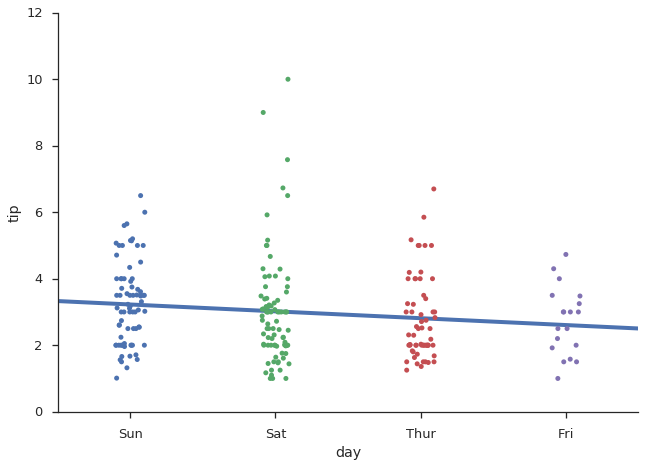

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style='ticks', context='talk')

# Fit just "tip ~ day", to make plotting easier
lm = LinearRegression()
lm.fit(X_factorized[['day']], y)
b0, b1 = lm.intercept_, lm.coef_.ravel()[0]

ax = sns.stripplot('day', 'tip', data=df, jitter=1)
xlim = ax.get_xlim()
xx = np.linspace(*xlim, 2)
ax.plot(xx, [3.2245 + b1 * xx[0], b0 + b1 * xx[1]], lw=4)
sns.despine()

This may not be true in practice, and our data representation should not force our model to assume it.
Better to let the model *discover* that relationship, if it actually happens to be there.

## Dummy Encoding

![dummy](dummy.png)

There's a better approach: dummy encoding.
This expands each categorical column to *multiple* columns, one per distinct value.
The values in these new dummy-encoded columns are either 1, indicating the presence of that value in that observation, or 0.
Versions of this are implemented in both scikit-learn and pandas.

I recommend the pandas version, `get_dummies`. It offers a few conveniences:

- Operates on multiple columns at once
- Passes through numeric columns unchanged
- Preserves row and column labels
- Provides a `drop_first` keyword for dropping a level per column. You might want this to avoid [perfect multicolinearity](https://en.wikipedia.org/wiki/Multicollinearity) if you have an intercept.

If you haven't heard of multicollinearity before, it's a problem that affects coefficient estimates in regression where two or more features are highly correlated with each other. Perfect Multicollinearity is an extreme case, where at least one of the features adds no new information. For example, we don't really need two columns to encode "smoker"; a value of 1 for `smoker_No` implies a value of 0 for `smoker_Yes`. That said, we won't really worry about it here.

In [20]:
X_dummy = pd.get_dummies(X)
X_dummy.head()

,total_bill,size,sex_Female,sex_Male,smoker_No,smoker_Yes,day_Fri,day_Sat,day_Sun,day_Thur,time_Dinner,time_Lunch
0,16.99,2,1,0,1,0,0,0,1,0,1,0
1,10.34,3,0,1,1,0,0,0,1,0,1,0
2,21.01,3,0,1,1,0,0,0,1,0,1,0
3,23.68,2,0,1,1,0,0,0,1,0,1,0
4,24.59,4,1,0,1,0,0,0,1,0,1,0


In [21]:
lm = LinearRegression()
lm.fit(X_dummy, y)

pd.Series(lm.coef_, index=X_dummy.columns)

total_bill     0.094487
size           0.175992
sex_Female     0.016220
sex_Male      -0.016220
smoker_No      0.043204
smoker_Yes    -0.043204
day_Fri        0.077300
day_Sat       -0.044159
day_Sun        0.051819
day_Thur      -0.084960
time_Dinner   -0.034064
time_Lunch     0.034064
dtype: float64

This version solves both of our issues with `factorize`.

1. The ordering of rows doesn't matter anymore because the dummy-columns are computed on the sorted version of the categories
2. "adjacent" categories each have their own parameter, so they're free to have their own effect

## Refinements

Our last approach worked, but there's still room for improvement.

1. We can't easily go from dummies back to categoricals
2. Doesn't integrate with scikit-learn `Pipeline` objects.
3. If working with a larger dataset and `partial_fit`, codes could be missing from subsets of the data.
4. Memory inefficient if there are many records relative to distinct categories

These items become more important when you go to "productionize" your model.
But keep in mind that we've solved the basic problem of moving from pandas DataFrames to NumPy arrays for scikit-learn; now we're just making the bridge sturdier.

To accomplish this we'll store additonal information in the *type* of the column and write a [Transformer](http://scikit-learn.org/stable/modules/generated/sklearn.base.TransformerMixin.html) to handle the conversion to and from dummies.

## Aside: scikit-learn Pipelines

Rarely when doing data analysis do we plug a raw dataset directly into a model.
There's typically some preprocessing and feature engineering before the fitting stage.
`scikit-learn` provides the `Pipeline` interface for chaining together a sequence of fit and transform steps. For example, suppose we wanted our pipeline to be

- standardize each column (subtract the mean, normalize the variance to 1)
- compute all the [interaction terms](https://en.wikipedia.org/wiki/Interaction_(statistics))
- fitting a Lasso regression

Without using a scikit-learn `Pipeline`, you need to assign the output of each step to a temporary variable, and manually shuttle data through to the end:

In [22]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Lasso

In [23]:
X_scaled = StandardScaler().fit_transform(X_dummy, y)
X_poly = (PolynomialFeatures(interaction_only=True)
            .fit_transform(X_scaled, y))
model = Lasso(alpha=.5)
model.fit(X_poly, y)

Lasso(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

With pipelines, this becomes:

In [24]:
from sklearn.pipeline import make_pipeline

In [25]:
pipe = make_pipeline(StandardScaler(),
                     PolynomialFeatures(interaction_only=True),
                     Lasso(alpha=.5))
pipe.fit(X_dummy, y)

Pipeline(steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=True, interaction_only=True)), ('lasso', Lasso(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))])

I always recommend the pipeline version.
For one thing, I prefer the aesthetics.
Especially with longer chains of computations, pipelines remove the need for many temporary variables.
They are also easier to save to disk with [joblib](https://pythonhosted.org/joblib/persistence.html).
But the most important reason is the interaction of `Pipeline` and [`GridSearchCV`](http://scikit-learn.org/stable/modules/grid_search.html).

When fitting a model you'll typically have a space of *hyperparameters* to search over.
These are the parameters passed to each estimator's `__init__` method, so before the `.fit` step.
In the pipeline above, some examples of hyperparameters are the `interaction_only` parameter of `PolynomialFeatures` and the `alpha` parameter of `Lasso`.

A common mistake in machine learning is to let information from your test dataset leak into your training dataset by preprocessing *before* splitting.
This means the score you get on the test may not be an accurate representation of the score you'll get on new data.

`scikit-learn` provides many tools for you to write custom transformers that work well in its `Pipeline`.
When writing a custom transformer, you should:

- inherit from `sklearn.base.TransformerMixin`
- implement a `.fit` method that takes a feature matrix `X` and a target array `y`, returning `self`.
- implement a `.transform` method that also takes an `X` and a `y`, returning the transformed feature matrix

Below, we'll write a couple of custom transformers to make our last regression more robust. But before that, we need to examine one of pandas' extension dtypes.

## Pandas `Categorical` dtype

Pandas provides a `Categorical` dtype, which stores

- All the possible values the column can take
- Whether there is an ordering on the categories
- A relationship between each distinct categorical value and an integer code

`Categorical`s can be constructed either with the `pd.Categorical` constructor, or using the `.astype` method on a `Series`. For example

In [26]:
day = df['day'].astype('category').head()
day.head()

0    Sun
1    Sun
2    Sun
3    Sun
4    Sun
Name: day, dtype: category
Categories (4, object): [Fri, Sat, Sun, Thur]

With `.astype('category')` we're just using the defaults of

- The set of categories is just the set present in the column
- There is no ordering

The categorical-specific information of a `Series` is stored under the `.cat` accessor.

In [27]:
day.cat.categories

Index(['Fri', 'Sat', 'Sun', 'Thur'], dtype='object')

In [28]:
day.cat.ordered

False

The following class is a transformer that transforms to categorical columns.

In [29]:
from sklearn.base import TransformerMixin

In [30]:
class CategoricalTransformer(TransformerMixin):
    "Converts a set of columns in a DataFrame to categoricals"
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, X, y=None):
        'Records the categorical information'
        self.cat_map_ = {col: X[col].astype('category').cat
                         for col in self.columns}
        return self

    def transform(self, X, y=None):
        X = X.copy()
        for col in self.columns:
            X[col] = pd.Categorical(X[col],
                                    categories=self.cat_map_[col].categories,
                                    ordered=self.cat_map_[col].ordered)
        return X
    
    def inverse_transform(self, trn, y=None):
        trn = trn.copy()
        trn[self.columns] = trn[self.columns].apply(lambda x: x.astype(object))
        return trn

The most important rule when writing custom objects to be used in a `Pipeline` is that the `transfrom` and `inverse_transform` steps shouldn't modify `self`. That should only occur in `fit`. Because we inherited from `TransformerMixin`, we get the `fit_transform` method.

In [31]:
ct = CategoricalTransformer(columns=['sex', 'smoker', 'day', 'time'])
X_cat = ct.fit_transform(X)
X_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 244 entries, 0 to 243
Data columns (total 6 columns):
total_bill    244 non-null float64
sex           244 non-null category
smoker        244 non-null category
day           244 non-null category
time          244 non-null category
size          244 non-null int64
dtypes: category(4), float64(1), int64(1)
memory usage: 6.8 KB


## DummyEncoder

We now have the pieces in place to solve all our issues.
We'll write a class `DummyEncoder` for use in a scikit-learn `Pipeline`.
The entirety is given in the next cell, but we'll break it apart piece by piece.

In [32]:
class DummyEncoder(TransformerMixin):
    
    def fit(self, X, y=None):
        self.columns_ = X.columns
        self.cat_cols_ = X.select_dtypes(include=['category']).columns
        self.non_cat_cols_ = X.columns.drop(self.cat_cols_)
        self.cat_map_ = {col: X[col].cat for col in self.cat_cols_}
        
        self.cat_blocks_ = {}  # {cat col: slice}
        left = len(self.non_cat_cols_)
        for col in self.cat_cols_:
            right = left + len(self.cat_map_[col].categories)
            self.cat_blocks_[col] = slice(left, right)
            left = right
        return self
    
    def transform(self, X, y=None):
        return np.asarray(pd.get_dummies(X))
    
    def inverse_transform(self, trn, y=None):
        numeric = pd.DataFrame(trn[:, :len(self.non_cat_cols_)],
                               columns=self.non_cat_cols_)
        series = []
        for col, slice_ in self.cat_blocks_.items():
            codes = trn[:, slice_].argmax(1)
            cat = self.cat_map_[col]
            cat = pd.Categorical.from_codes(codes,
                                            cat.categories,
                                            cat.ordered)
            series.append(pd.Series(cat, name=col))
        return pd.concat([numeric] + series, axis='columns')[self.columns_]

self = DummyEncoder()
trn = self.fit_transform(X_cat)
trn

array([[ 16.99,   2.  ,   1.  , ...,   0.  ,   1.  ,   0.  ],
       [ 10.34,   3.  ,   0.  , ...,   0.  ,   1.  ,   0.  ],
       [ 21.01,   3.  ,   0.  , ...,   0.  ,   1.  ,   0.  ],
       ..., 
       [ 22.67,   2.  ,   0.  , ...,   0.  ,   1.  ,   0.  ],
       [ 17.82,   2.  ,   0.  , ...,   0.  ,   1.  ,   0.  ],
       [ 18.78,   2.  ,   1.  , ...,   1.  ,   1.  ,   0.  ]])

The transform method is the simplest; it's using `pd.get_dummies` as we did before. That is wrapped in a `np.asarray` to convert the DataFrame to a NumPy array, simulating what would happen if we pass the dummy-encoded class to a scikit-learn transformer that deals with NumPy arrays.

The rest of the class is really just there for the `inverse_transform` method.
In `.fit`, we need to store all the information needed to take the `trn` NumPy array and go back to a `DataFrame`. This includes

- Column names (`self.columns_`)
- Cateogrical information (`self.cat_map_`)
- Mapping original columns to transformed positions (`self.non_cat_cols_` and `self.cat_blocks_`)

The first thing to realize is that pandas `get_dummies` returns the un-touched (numeric) columns first. We had two of those, `total_bill` and `size`, and collect those first in `inverse_transform`.

In [33]:
numeric = pd.DataFrame(trn[:, :len(self.non_cat_cols_)],
                       columns=self.non_cat_cols_)
numeric.head()

,total_bill,size
0,16.99,2
1,10.34,3
2,21.01,3
3,23.68,2
4,24.59,4


While we had two columns in this dataset, in general we'll have `len(self.non_cat_cols_)`.

The rest of `inverse_transform` deals with `categoricals`.
We have two separate tasks here.

1. Know which of the expanded columns in `trn` belong to which original categorical columns
2. Know the categorical attributes (`ordered`, `categories`) for that categorical

For the first task, we use the information stored in `self.cat_blocks_`. This is a dictonary mapping categorical column names to `slice` objects, that can be used on `trn`.

In [34]:
self.cat_blocks_

{'day': slice(6, 10, None),
 'sex': slice(2, 4, None),
 'smoker': slice(4, 6, None),
 'time': slice(10, 12, None)}

In [35]:
trn[:, self.cat_blocks_['day']][:5]

array([[ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  1.,  0.]])

Each of these "blocks" contain the dummy-encoded categorical. To invert the dummy-encoded, we use the fact that each row only has a single `1`, meaning that the maximum value of the row is the category for that row. We'll find the `argmax` for each row.

In [36]:
codes = trn[:, self.cat_blocks_['day']].argmax(1)
codes[:5]

array([2, 2, 2, 2, 2])

Now we'll use the alternative `Categorical.from_codes` constructor, which is appropriate when you have an array of `codes`, and already know the `categories` and `ordered`. We've stored that categorical information in the `self.cat_map_` dictionary.

In [37]:
cat = pd.Categorical.from_codes(codes, self.cat_map_['day'].categories,
                                self.cat_map_['day'].ordered)
cat

[Sun, Sun, Sun, Sun, Sun, ..., Sat, Sat, Sat, Sat, Thur]
Length: 244
Categories (4, object): [Fri, Sat, Sun, Thur]

The rest of `inverse_transform` collects all the series of `Categorical` and concats them together with the `numeric` columns.

## Using our pipeline

In [38]:
columns = ['sex', 'smoker', 'day', 'time']
pipe = make_pipeline(CategoricalTransformer(columns), DummyEncoder(), LinearRegression())
pipe.fit(X, y)

Pipeline(steps=[('categoricaltransformer', <__main__.CategoricalTransformer object at 0x7fc5084095f8>), ('dummyencoder', <__main__.DummyEncoder object at 0x7fc5084092b0>), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

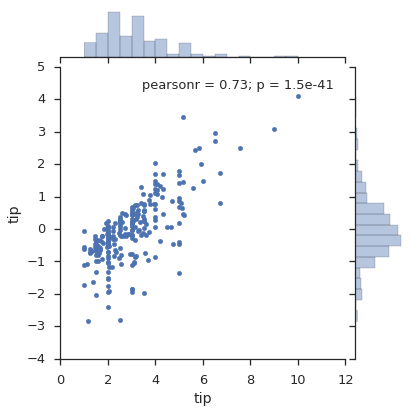

In [39]:
yhat = pipe.predict(X)
sns.jointplot(y, y-yhat)

In [40]:
from sklearn.decomposition import PCA

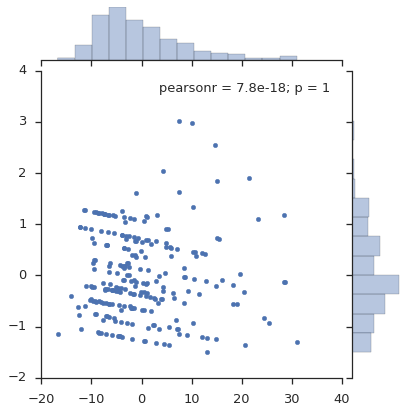

In [41]:
pipe = make_pipeline(CategoricalTransformer(columns), DummyEncoder(), PCA())
trn = pipe.fit_transform(X)
sns.jointplot(trn[:, 0], trn[:, 1]);

In [42]:
pipe.inverse_transform(trn).head()

,total_bill,sex,smoker,day,time,size
0,16.99,Female,No,Sun,Dinner,2
1,10.34,Male,No,Sun,Dinner,3
2,21.01,Male,No,Sun,Dinner,3
3,23.68,Male,No,Sun,Dinner,2
4,24.59,Female,No,Sun,Dinner,4


# Summary

We explored some of the differences between the scikit-learn (NumPy) and pandas data models.
We needed to convert a heterogeneous pandas `DataFrame` to a homogonous `ndarray` for use in scikit-learn.
Specifically we used `pd.get_dummies` to dummy encode the categorical data.
After dummy encoding, we sucessfully fit the model. 

For a more robust method, we implmented two scikit-learn `Pipeline` compatible transformers.
The first converted columns of strings into proper pandas `Categorical`s.
The second used `pd.get_dummies` to transform `Categoricals`, storing all the information needed to reverse the transformation.